**RDS (DS-UA 202) Spring 2022: Homework 1 Template**


This notebook is a template for problem 2. You should save a copy of this notebook and write your code in that copy. The code to setup the analysis is provided for you here. You should not edit or add to the setup code.

Some suggested steps are included as comments in the below code cells. You do not need to follow these suggestions (other solutions or approaches are acceptable).

# Setup

## Packages

In [1]:
!git clone https://github.com/lurosenb/superquail
!pip install aif360==0.3.0 
!pip install BlackBoxAuditing
!pip install tensorflow==1.13.1
!pip install folktables

Cloning into 'superquail'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 24 (delta 1), reused 20 (delta 1), pack-reused 0
Unpacking objects: 100% (24/24), done.
     |████████████████████████████████| 165 kB 7.6 MB/s 
     |████████████████████████████████| 2.6 MB 8.4 MB/s 
  Created wheel for BlackBoxAuditing: filename=BlackBoxAuditing-0.1.54-py2.py3-none-any.whl size=1394770 sha256=cddd093e45cc374fe5677c87b1be9d99284f76ae65f94b9c4835bf093690bddd
  Stored in directory: /root/.cache/pip/wheels/05/9f/ee/541a74be4cf5dad17430e64d3276370ea7b6a834a76cb4215a
Successfully built BlackBoxAuditing
     |████████████████████████████████| 92.6 MB 1.2 MB/s 
     |████████████████████████████████| 3.2 MB 38.2 MB/s 
     |████████████████████████████████| 50 kB 6.6 MB/s 
     |████████████████████████████████| 367 kB 56.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing install

In [2]:
import random
random.seed(6)

import sys
import warnings

import numpy as np
import pandas as pd
import tensorflow as tf
import json
import time 
from tqdm import tqdm

import matplotlib.pyplot as plt 
import seaborn as sns

from folktables import ACSDataSource, ACSEmployment, ACSIncome, ACSPublicCoverage, ACSTravelTime
from superquail.data.acs_helper import ACSData

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from aif360.datasets import BinaryLabelDataset, StandardDataset
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.algorithms.inprocessing import PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, RejectOptionClassification
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.metrics import BinaryLabelDatasetMetric

import BlackBoxAuditing
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

## Load data

We have included code to read in the folktables dataset. The Folktables dataset is taken from US Census Data and is built to solve a few simple prediction tasks. The sample we pull is data from 2018 in California. The column names are described in the table below. Note that certain categorical variables have been mapped to integer values, which we will keep as is for the following analyses.

For more information on the this dataset, please see the following paper:
https://eaamo2021.eaamo.org/accepted/acceptednonarchival/EAMO21_paper_16.pdf

| Column Name | Feature | Description/Notes |
| --- | ----------- | --- |
| PINCP | Total person’s income | (Target) 1 if >= $50k, 0 if less |
| SEX | Sex | (Sensitive Attribute) Male=1, Female=2 |
| RAC1P | Race | Dropped from this analysis to focus on one sensitive attribute |
| AGEP | Age | Ranges from 0-99 |
| COW | Class of Worker | Ranges 1-9, see paper for description |
| SCHL | Education Level | Ranges 1-24, see paper for description |
| MAR | Marital Status | Ranges 1-5, see paper for description |
| OCCP | Occupation | Codes taken from Public Use Microdata Sample (PUMS) from the US Census, see paper |
| POBP | Place of Birth | Codes taken from Public Use Microdata Sample (PUMS) from the US Census, see paper |
| RELP | Relationship | Relationship of individual to person who responded to the Census taker. Ranges 0-17, see paper for description |
| WKHP | Hours worked per week | Ranges from 0-99, averaged over previous year |

In [3]:
np.random.seed(13) # do not change the seed

# read in the folktables dataset 
full_df, features_df, target_df, groups_df = ACSData().return_acs_data_scenario(scenario="ACSIncome", subsample=30000)
full_df = full_df.drop(columns='RAC1P') # drop race -- another protected attribute from our dataset

print(full_df.shape)
full_df.head()

(30000, 10)


,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,PINCP
0,44.0,1.0,1.0,1.0,4220.0,6.0,10.0,40.0,1.0,0.0
1,66.0,2.0,20.0,2.0,4720.0,42.0,0.0,32.0,2.0,0.0
2,72.0,6.0,18.0,1.0,10.0,6.0,1.0,8.0,2.0,1.0
3,53.0,1.0,21.0,1.0,1460.0,457.0,0.0,40.0,1.0,1.0
4,55.0,1.0,16.0,1.0,220.0,6.0,1.0,40.0,1.0,0.0


## Set protected attribute and target

In [4]:
protected_attr = 'SEX' # set sex as the protected attribute
target = 'PINCP' # personal income as the target, note that [1 = >50k]

In [5]:
# convert this dataframe into an aif360 dataset
original_data = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=full_df,
    label_names=[target],
    protected_attribute_names=[protected_attr])
privileged_groups = [{protected_attr: 1}] 
unprivileged_groups = [{protected_attr: 2}]

## Split data

In [6]:
seed = 50
train_data, test_data = original_data.split([0.8], shuffle=True, seed=seed)

## Scale features in the data

In [18]:
scaler = MinMaxScaler()

train_data.features = scaler.fit_transform(train_data.features)
test_data.features = scaler.transform(test_data.features)

# convert to dataframes
train_df, _ = train_data.convert_to_dataframe()
test_df, _ = test_data.convert_to_dataframe()
print("Training set: ", train_df.shape)
print("Test set: ", test_df.shape)

# extract x (features) and y (target)
train_x = train_df.drop([target, protected_attr], axis=1)
train_y = train_df[target]
test_x = test_df.drop([target, protected_attr], axis=1)
test_y = test_df[target]

Training set:  (24000, 10)
Test set:  (6000, 10)


# 2 (a)

## Train a random forest model (baseline)

In [19]:
# use these hyperparameters in your call to RandomForestClassifier
n_estimators = 20
max_depth = 10

# set up the random forest model, using the hyperparameters
clf=RandomForestClassifier(n_estimators=20, max_depth=10)

# fit the model using the training data (train_x, train_y)
initial_clf = clf.fit(train_x,train_y)

## Calculate metrics

In [20]:
# the below function has been provided for you. You can use this function to
# convert your data to a StandardDataset format for use in AIF360
def transform_to_aif(df, target=target, protected_attr=protected_attr):
  '''convert a pandas.DataFrame to a StandardDataset used in AIF360'''

  sd = StandardDataset(
      df,
      label_name = target,
      favorable_classes = [1],
      protected_attribute_names = [protected_attr],
      privileged_classes = [[1]]
  )

  return sd

In [21]:
# calculate predictions from baseline RF model
test_preds_df = test_df.copy()
test_preds_df[target] = initial_clf.predict(test_x)
# convert predictions data to AIF StandardDataset
test_preds_df_AIF = transform_to_aif(test_preds_df)
# also create AIF StandardDataset versions of training and test data
train_df_AIF = transform_to_aif(train_df)
test_df_AIF = transform_to_aif(test_df)

In [22]:
# calculate metrics
pred_metrics = BinaryLabelDatasetMetric(test_preds_df_AIF,
                                        unprivileged_groups=unprivileged_groups, 
                                        privileged_groups=privileged_groups)

orig_vs_preds_metrics = ClassificationMetric(test_df_AIF, test_preds_df_AIF,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)


print("Overall accuracy = %f" % orig_vs_preds_metrics.accuracy())
print("Accuracy for the privileged group = %f" % orig_vs_preds_metrics.accuracy(privileged=True))
print("Accuracy for the unprivileged group = %f" % orig_vs_preds_metrics.accuracy(privileged=False))
print("Disparate Impact = %f" % orig_vs_preds_metrics.disparate_impact())
print("False positive rate difference = %f" % orig_vs_preds_metrics.false_positive_rate_difference())

Overall accuracy = 0.802500
Accuracy for the privileged group = 0.803107
Accuracy for the unprivileged group = 0.801827
Disparate Impact = 0.828183
False positive rate difference = 0.004315


# 2 (b)

## Transform the original data using Disparate Impact Remover at five repair levels and calculate metrics

In [23]:
# the below function has been provided for you. You can use this function to
# plot the repair_level (on the x-axis) against a given metric,
# e.g. accuracy, on the y-axis
def plot_metric_repair(repair_levels, metric_values, metric_name):
  '''Creates a line plot showing how the metric changed for different values of repair level'''

  # Plot the metrics
  plt.plot(repair_levels, metric_values, color='#0384fc', linewidth=3, label=metric_name)

  # Create labels, etc. 
  plt.xlabel('Repair level')
  plt.ylabel(metric_name)
  plt.legend()
  plt.show()

In [35]:
# use these repair levels
repair_levels = [0, 0.25, 0.5, 0.75, 1]

# transform the test and training data using DI-remover at the above repair
# levels and calculate metrics (you may wish to use a for loop)

overallAccuracy = []
unprivilegedAccuracy = []
privilegedAccuracy = []
disparateImpact = []
fprd = []

for level in repair_levels:
  print("For Repair Level " + str(level) + ":\n")
  diRemover = DisparateImpactRemover(repair_level = level, 
                                      sensitive_attribute = protected_attr)
  test_di = diRemover.fit_transform(dataset=test_df_AIF)
  train_di = diRemover.fit_transform(dataset=train_df_AIF)

  test_df, _ = test_di.convert_to_dataframe()
  train_df, _ = train_di.convert_to_dataframe()
  x_train_di = train_df.drop([target, protected_attr],axis=1)
  y_train_di = train_df[target]
  x_test_di = test_df.drop([target, protected_attr],axis=1)
  y_test_di = test_df[target]

  clf.fit(x_train_di, y_train_di)
  pred_df = test_df.copy()
  pred_df[target] = clf.predict(x_test_di)
  predAif = transform_to_aif(pred_df, target=target, protected_attr = protected_attr)
  pred_metrics = BinaryLabelDatasetMetric(predAif,
                                          unprivileged_groups=unprivileged_groups,
                                          privileged_groups=privileged_groups)

  old_vs_pred_metrics = ClassificationMetric(test_di,predAif, 
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)
  
  print("Accuracy (Overall) = %f" % old_vs_pred_metrics.accuracy())
  print("Accuracy (Privileged Group) = %f" % old_vs_pred_metrics.accuracy(privileged=True))
  print("Accuracy (Unprivileged Group) = %f" % old_vs_pred_metrics.accuracy(privileged=False))
  print("Disparate Impact = %f" % old_vs_pred_metrics.disparate_impact())
  print("False Positive Rate Difference = %f" % old_vs_pred_metrics.false_positive_rate_difference())
  print()
  print("----------------------------------------------------")
  print()
  overallAccuracy.append(old_vs_pred_metrics.accuracy())
  unprivilegedAccuracy.append(old_vs_pred_metrics.accuracy(privileged=False))
  privilegedAccuracy.append(old_vs_pred_metrics.accuracy(privileged=True))
  disparateImpact.append(old_vs_pred_metrics.disparate_impact())
  fprd.append(old_vs_pred_metrics.false_positive_rate_difference())



For Repair Level 0:

Accuracy (Overall) = 0.802333
Accuracy (Privileged Group) = 0.801205
Accuracy (Unprivileged Group) = 0.803584
Disparate Impact = 0.859372
False Positive Rate Difference = 0.012527

----------------------------------------------------

For Repair Level 0.25:

Accuracy (Overall) = 0.792833
Accuracy (Privileged Group) = 0.777108
Accuracy (Unprivileged Group) = 0.810260
Disparate Impact = 1.011359
False Positive Rate Difference = 0.047480

----------------------------------------------------

For Repair Level 0.5:

Accuracy (Overall) = 0.789500
Accuracy (Privileged Group) = 0.779011
Accuracy (Unprivileged Group) = 0.801124
Disparate Impact = 0.971942
False Positive Rate Difference = 0.044817

----------------------------------------------------

For Repair Level 0.75:

Accuracy (Overall) = 0.786000
Accuracy (Privileged Group) = 0.766646
Accuracy (Unprivileged Group) = 0.807449
Disparate Impact = 1.105138
False Positive Rate Difference = 0.069161

----------------------

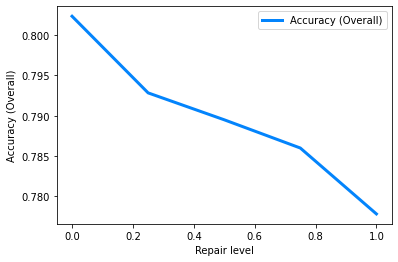

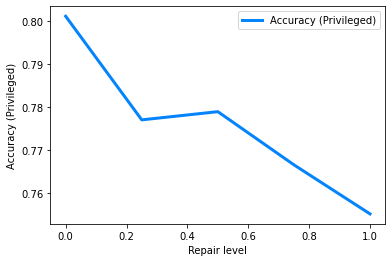

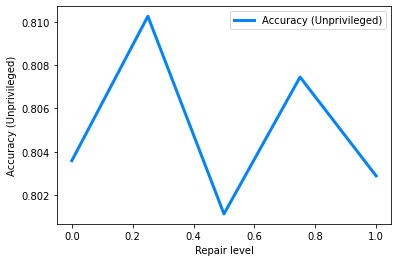

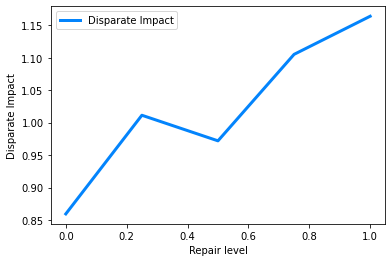

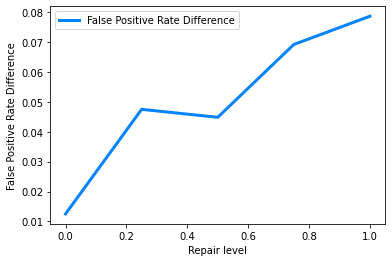

In [37]:
# plot each metric against the repair level
# (you can use the plot_metric_repair above)
plot_metric_repair(repair_levels=repair_levels, metric_values=overallAccuracy, metric_name= "Accuracy (Overall)")
print()
plot_metric_repair(repair_levels=repair_levels, metric_values=privilegedAccuracy, metric_name= "Accuracy (Privileged)")
print()
plot_metric_repair(repair_levels=repair_levels, metric_values=unprivilegedAccuracy, metric_name= "Accuracy (Unprivileged)")
print()
plot_metric_repair(repair_levels=repair_levels, metric_values=disparateImpact, metric_name= "Disparate Impact")
print()
plot_metric_repair(repair_levels=repair_levels, metric_values=fprd, metric_name= "False Positive Rate Difference")

# 2 (c) 


## Train a Prejudice Remover model at three eta values and calculate metrics


In [43]:
etas = [0.01, 0.1, 1] # eta is the weight we apply to the fairness regularization parameter

# train a Prejudice Remover model at these eta values and calculate metrics
# (you may wish to use a for loop)
overallAccuracy = []
unprivilegedAccuracy = []
privilegedAccuracy = []
disparateImpact = []
fprd = []

for eta in etas:
  prem = PrejudiceRemover(eta=eta, sensitive_attr=protected_attr)
  prem.fit(dataset=train_df_AIF)
  predAif = prem.predict(test_df_AIF)
  predict_metrics = BinaryLabelDatasetMetric(predAif,
                                              unprivileged_groups = unprivileged_groups,
                                              privileged_groups = privileged_groups
  )
  old_vs_pred_metrics = ClassificationMetric(test_df_AIF,predAif,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
  
  overallAccuracy.append(old_vs_pred_metrics.accuracy())
  privilegedAccuracy.append(old_vs_pred_metrics.accuracy(privileged=True))
  unprivilegedAccuracy.append(old_vs_pred_metrics.accuracy(privileged=False))
  disparateImpact.append(old_vs_pred_metrics.disparate_impact())
  fprd.append(old_vs_pred_metrics.false_positive_rate_difference())


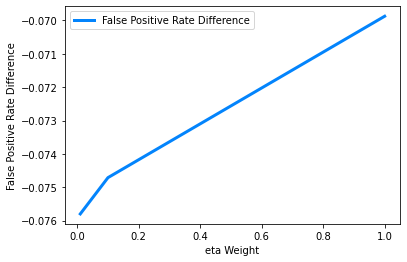

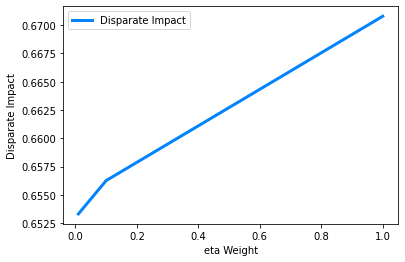

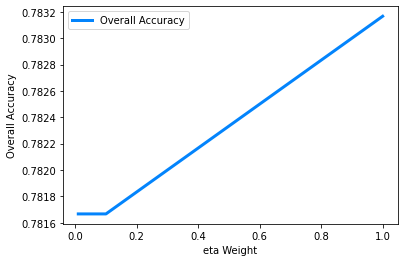

In [44]:
# plot one or more of the metrics varies at the different values of eta
def plot_metric(etas, metric_values, metric_name):
  '''Creates a line plot showing how the metric changed for different values of repair level'''

  # Plot the metrics
  plt.plot(etas, metric_values, color='#0384fc', linewidth=3, label=metric_name)

  # Create labels, etc. 
  plt.xlabel('eta Weight')
  plt.ylabel(metric_name)
  plt.legend()
  plt.show()

plot_metric(etas=etas, metric_values=fprd, metric_name= "False Positive Rate Difference")
print()
plot_metric(etas=etas, metric_values=disparateImpact, metric_name= "Disparate Impact")
print()
plot_metric(etas=etas, metric_values=overallAccuracy, metric_name= "Overall Accuracy")
